# Лабораторная работа 2. Обучение нейронной сети

In [158]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [159]:
torch.manual_seed(42)

Сгенерируем обучающие и валидационные данные для экспериментов.

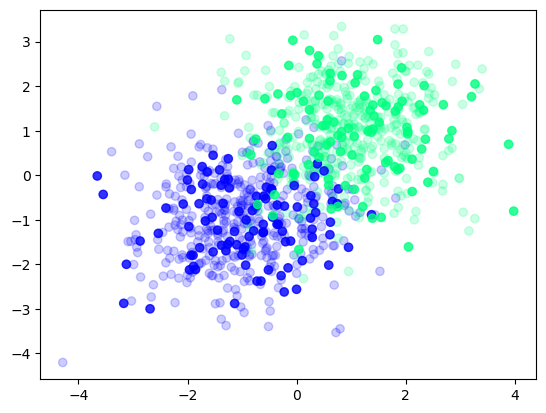

In [160]:
n_samples = 1000
half = int(n_samples / 2)
     
x_class0 = np.random.normal(size=[half, 2]) + [-1, -1]
y_class0 = np.zeros((half, 1))
x_class1 = np.random.normal(size=[half, 2]) + [1, 1]
y_class1 = np.ones((half, 1))

train_half = int(0.8*half)
train_X = np.vstack([x_class0[:train_half], x_class1[:train_half]])
train_y = np.vstack([y_class0[:train_half], y_class1[:train_half]])
val_X = np.vstack([x_class0[train_half:], x_class1[train_half:]])
val_y = np.vstack([y_class0[train_half:], y_class1[train_half:]])

train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.float32)
val_X = val_X.astype(np.float32)
val_y = val_y.astype(np.float32)

plt.scatter(train_X[:,0], train_X[:,1], c=train_y, cmap='winter', alpha=0.2)
plt.scatter(val_X[:,0], val_X[:,1], c=val_y, cmap='winter', alpha=0.8)

Преобразуем данные из `numpy.ndarray` в `torch.Tensor`.

In [161]:
f = lambda x: torch.from_numpy(x)

train_X = f(train_X)
train_y = f(train_y)
val_X = f(val_X)
val_y = f(val_y)

## Задание 1
Создайте класс нейронной сети состоящей из входного линейного слоя, функции активации `nn.ReLu()`, скрытого слоя и функции `nn.Sigmoid()`. Предусмотрите возможность задавать количество нейронов скрытого слоя через аргумент в конструкторе класса (по умолчанию скрытый слой будет состоять из 2-ух нейронов).

Инициализируйте нейронную сеть по умолчанию. Вычислите `accuracy` предсказания на валидационной подвыборке сгенерированных данных.

Обучите нейронную сеть на обучающей подвыборке сгенерированных данных и проверьте точность на валидационной подвыборке при следующих значениях гиперпараметров:
* скорость обучения `0.1`,
* оптимизатор `torch.optim.SGD`,
* количество эпох `10`.

Вычислите `accuracy` предсказания на валидационной подвыборке сгенерированных данных от обученной нейронной сети.

Ответьте письмено на следующие вопросы:
1. Какой количество нейронов в созданной нейронной сети?
2. Какой количество параметров (весов) в созданной нейронной сети?
3. Что предсказывает созданной нейронная сеть?
4. Что следует изменить в архитектуре созданной нейронной сети в случае решения задачи многоклассовой классификации?

In [162]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from torchsummary import summary

# Создаем класс нейронной сети
class SimpleNN(nn.Module):
    def __init__(self, hidden_size=2): # По умолчанию 2 нейрона
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)  # Входной слой (2 признака)
        self.relu = nn.ReLU()                  # Функция активации
        self.fc2 = nn.Linear(hidden_size, 1)   # Скрытый слой
        self.sigmoid = nn.Sigmoid()            # Функция активации выхода
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x.squeeze()

# Инициализация данных и модели
for hidden_size in range(2, 6):
    print(f'\nhidden_size = {hidden_size}')
    model = SimpleNN(hidden_size=hidden_size)  # Скрытый слой из 2 нейронов по умолчанию
    #summary(model, input_size=(2,))  # Устанавливаем размер входа
    print(f'\nКоличество нейронов = {2+hidden_size+1}')
    print(f'Количество параметров (весов) = {(2*hidden_size+hidden_size)+0+(hidden_size*1+1)+0}\n') # Суммируется по каждому слою (кол-во входов * кол-во выходов + кол-во смещений)
    # Вычисление accuracy до обучения
    with torch.no_grad():
        predictions = model(val_X)
        pred_labels = (predictions > 0.5).float()
        initial_accuracy = accuracy_score(val_y.squeeze().numpy(), pred_labels.numpy())
    print(f"Accuracy до обучения: {initial_accuracy:.4f}")
    
    # Обучение модели
    fn_loss = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    n_epochs = 10
    for epoch in range(n_epochs):
        # Forward pass
        predictions = model(train_X)
        loss = fn_loss(predictions.squeeze(), train_y.squeeze().float())
        
        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Вывод прогресса
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
    
    # Вычисление accuracy после обучения
    with torch.no_grad():
        predictions = model(val_X)
        pred_labels = (predictions > 0.5).float()
        trained_accuracy = accuracy_score(val_y.squeeze().numpy(), pred_labels.numpy())
    print(f"Accuracy после обучения: {trained_accuracy:.4f}")


hidden_size = 2

Количество нейронов = 5
Количество параметров (весов) = 9

Accuracy до обучения: 0.4950
Epoch [1/10], Loss: 0.7687
Epoch [2/10], Loss: 0.7600
Epoch [3/10], Loss: 0.7517
Epoch [4/10], Loss: 0.7437
Epoch [5/10], Loss: 0.7359
Epoch [6/10], Loss: 0.7284
Epoch [7/10], Loss: 0.7210
Epoch [8/10], Loss: 0.7139
Epoch [9/10], Loss: 0.7068
Epoch [10/10], Loss: 0.7000
Accuracy после обучения: 0.5000

hidden_size = 3

Количество нейронов = 6
Количество параметров (весов) = 13

Accuracy до обучения: 0.5000
Epoch [1/10], Loss: 0.6991
Epoch [2/10], Loss: 0.6870
Epoch [3/10], Loss: 0.6756
Epoch [4/10], Loss: 0.6650
Epoch [5/10], Loss: 0.6549
Epoch [6/10], Loss: 0.6452
Epoch [7/10], Loss: 0.6359
Epoch [8/10], Loss: 0.6270
Epoch [9/10], Loss: 0.6183
Epoch [10/10], Loss: 0.6098
Accuracy после обучения: 0.9000

hidden_size = 4

Количество нейронов = 7
Количество параметров (весов) = 17

Accuracy до обучения: 0.1950
Epoch [1/10], Loss: 0.8506
Epoch [2/10], Loss: 0.8234
Epoch [3/10], Loss: 

**Ответы на вопросы:**
1. Количество нейронов определяется по формуле сумма количества входных параметров каждого слоя + 1 (выходной слой)
2. Количество параметров (весов) определяется по формуле сумма по каждому слою (кол-во входов * кол-во выходов + кол-во смещений)
3. Данная нейронная сеть решает задачу бинарной классификации, тип предсказания - вероятность бинарной классификации
4. Для многоклассовой классификации необходимо внести следующие изменения:
   
   а) Выходной слой: nn.Linear(hidden_size, N)  # N нейронов вместо 1

   б) Функция активации: nn.Softmax(dim=1)  # Вместо Sigmoid

   в) Функция потерь: nn.CrossEntropyLoss()  # Вместо BCELoss

   г) Размерность целевых переменных: y_train должен содержать классы (0 до N-1), а не one-hot encoding

## Задание 2
Добавьте вывод точности на валиадационной подвыборке в конце каждой эпохи обучения.

Проведите следующие эксперименты:
* Исследуйте `train_loss`, `val_loss` и `accuracy` в процессе обучения нейронной сети при разной `скорости обучения` (0.1, 0.01, 0.001, 0.0001). Визуализируйте результаты и сделайте выводы.
* Исследуйте `train_loss`, `val_loss` и `accuracy` в процессе обучения нейронной сети при разном `количестве нейронов в скрытом слое` (2, 20, 200). Визуализируйте результаты и сделайте выводы.

In [163]:
from itertools import product

list_lr = [0.0001,  0.001, 0.01, 0.1]
list_hidden_size = [2, 20, 200]

train_loss = []
val_loss = []
accuracy = []

for lr, hidden_size in product(list_lr, list_hidden_size):
    # Инициализация данных и модели
    model = SimpleNN(hidden_size=hidden_size)  # Скрытый слой из 2 нейронов по умолчанию
    print(f'\nhidden_size = {hidden_size}, lr = {lr}')  
    print(f'Количество нейронов = {2+hidden_size+1}')
    print(f'Количество параметров (весов) = {(2*hidden_size+hidden_size)+0+(hidden_size*1+1)+0}\n') # Суммируется по каждому слою (кол-во входов * кол-во выходов + кол-во смещений)
  
    # Вычисление accuracy до обучения
    with torch.no_grad():
        predictions = model(val_X)
        pred_labels = (predictions > 0.5).float()
        initial_accuracy = accuracy_score(val_y.squeeze().numpy(), pred_labels.numpy())
    print(f"Accuracy до обучения: {initial_accuracy:.4f}")
    
    # Обучение модели
    fn_loss = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.SGD(model.parameters(), lr=lr)

    tr_loss = []
    v_loss = []
    acc = []
    n_epochs = 10
    for epoch in range(n_epochs):
        # Forward pass
        predictions = model(train_X)
        loss = fn_loss(predictions.squeeze(), train_y.squeeze().float())

        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            predictions = model(train_X)
            loss = fn_loss(predictions.squeeze(), train_y.squeeze().float())
            tr_loss.append(loss.item())

            predictions_val = model(val_X)
            loss_val = fn_loss(predictions_val.squeeze(), val_y.squeeze().float())
            v_loss.append(loss_val.item())
        
            pred_labels = (predictions_val > 0.5).float()
            trained_accuracy = accuracy_score(val_y.squeeze().numpy(), pred_labels.numpy())
            #print(f"Accuracy после обучения: {trained_accuracy:.4f}")
            acc.append(trained_accuracy)
            
        # Вывод прогресса
        print(f'Epoch [{epoch+1}/{n_epochs}], train_Loss: {loss.item():.4f}, val_Loss: {loss_val.item():.4f}, accuracy на валидации: {trained_accuracy}')

    train_loss.append(tr_loss)
    val_loss.append(v_loss)
    accuracy.append(acc)

    # Вычисление accuracy после обучения
    with torch.no_grad():
        predictions = model(val_X)
        pred_labels = (predictions > 0.5).float()
        trained_accuracy = accuracy_score(val_y.squeeze().numpy(), pred_labels.numpy())
    print(f"Accuracy после обучения: {trained_accuracy:.4f}")



hidden_size = 2, lr = 0.0001
Количество нейронов = 5
Количество параметров (весов) = 9

Accuracy до обучения: 0.2950
Epoch [1/10], train_Loss: 0.7838, val_Loss: 0.7877, accuracy на валидации: 0.295
Epoch [2/10], train_Loss: 0.7838, val_Loss: 0.7877, accuracy на валидации: 0.295
Epoch [3/10], train_Loss: 0.7838, val_Loss: 0.7877, accuracy на валидации: 0.295
Epoch [4/10], train_Loss: 0.7838, val_Loss: 0.7877, accuracy на валидации: 0.295
Epoch [5/10], train_Loss: 0.7838, val_Loss: 0.7876, accuracy на валидации: 0.295
Epoch [6/10], train_Loss: 0.7838, val_Loss: 0.7876, accuracy на валидации: 0.295
Epoch [7/10], train_Loss: 0.7838, val_Loss: 0.7876, accuracy на валидации: 0.295
Epoch [8/10], train_Loss: 0.7838, val_Loss: 0.7876, accuracy на валидации: 0.295
Epoch [9/10], train_Loss: 0.7838, val_Loss: 0.7876, accuracy на валидации: 0.295
Epoch [10/10], train_Loss: 0.7838, val_Loss: 0.7876, accuracy на валидации: 0.295
Accuracy после обучения: 0.2950

hidden_size = 20, lr = 0.0001
Количест

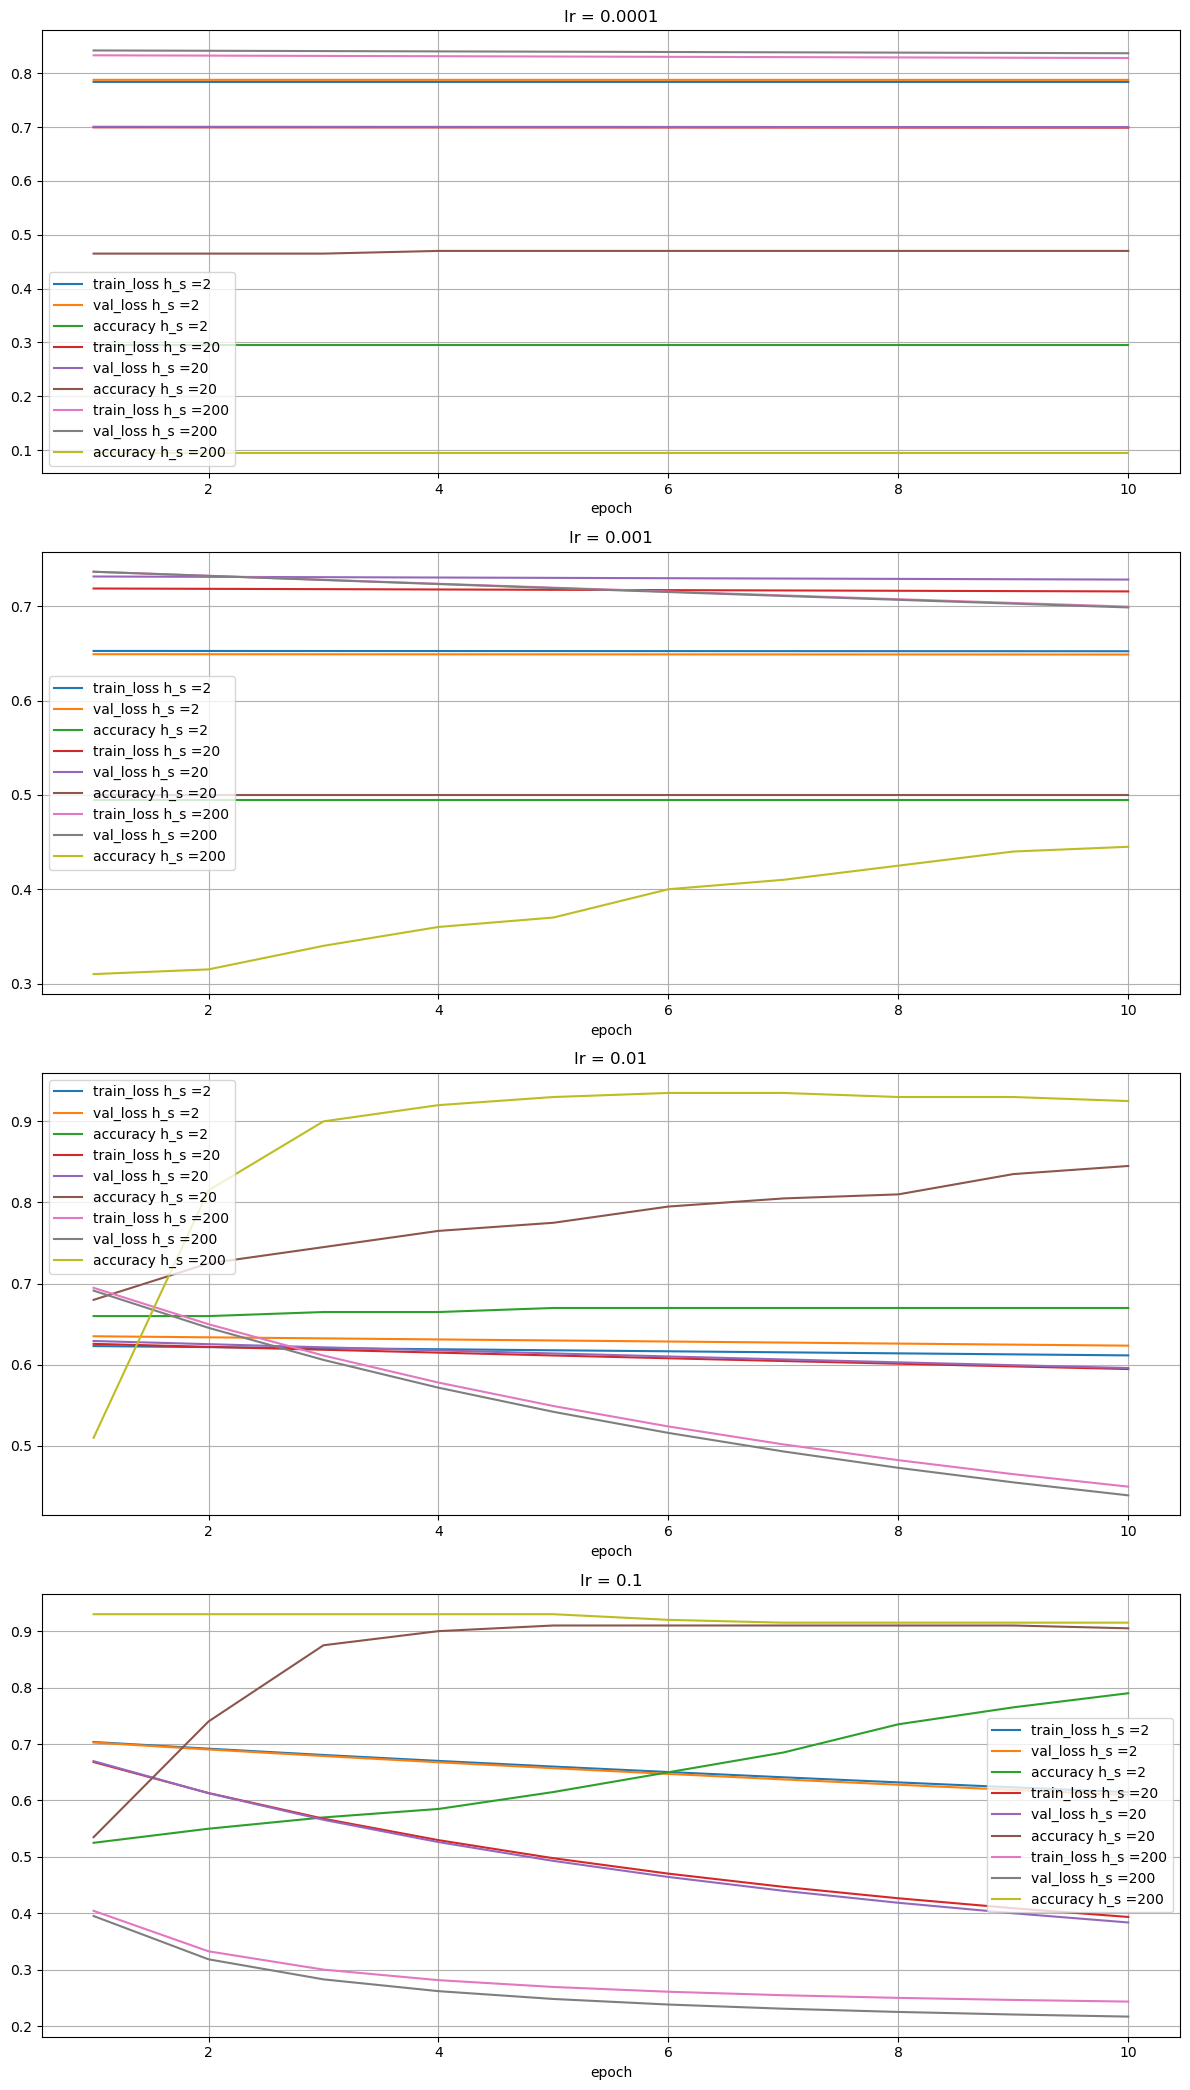

In [164]:
# Визуализация обучения
# Исследование `train_loss`, `val_loss` и `accuracy` в процессе обучения нейронной сети при разной `скорости обучения` (0.1, 0.01, 0.001, 0.0001).

# 12 различных цветов (HEX-формат)
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#aec7e8', '#ffbb78'
]

plt.figure(figsize=(12, 21))
x = [i for i in range(1,11)]
for i in range(len(list_lr)):
    k=0
    for j in range(len(list_hidden_size)):
        plt.subplot(len(list_lr), 1, i+1)
        plt.plot(x, train_loss[i*len(list_hidden_size)+j], color=colors[k], label='train_loss h_s ='+str(list_hidden_size[j]))
        plt.plot(x, val_loss[i*len(list_hidden_size)+j], color=colors[k+1], label='val_loss h_s ='+str(list_hidden_size[j]))
        plt.plot(x, accuracy[i*len(list_hidden_size)+j], color=colors[k+2], label='accuracy h_s ='+str(list_hidden_size[j]))
        k+=3    
    plt.title(f'lr = {list_lr[i]}')
    plt.grid(True)
    plt.legend()
    plt.xlabel('epoch')
        #plt.ylabel('')
plt.tight_layout()
plt.show()

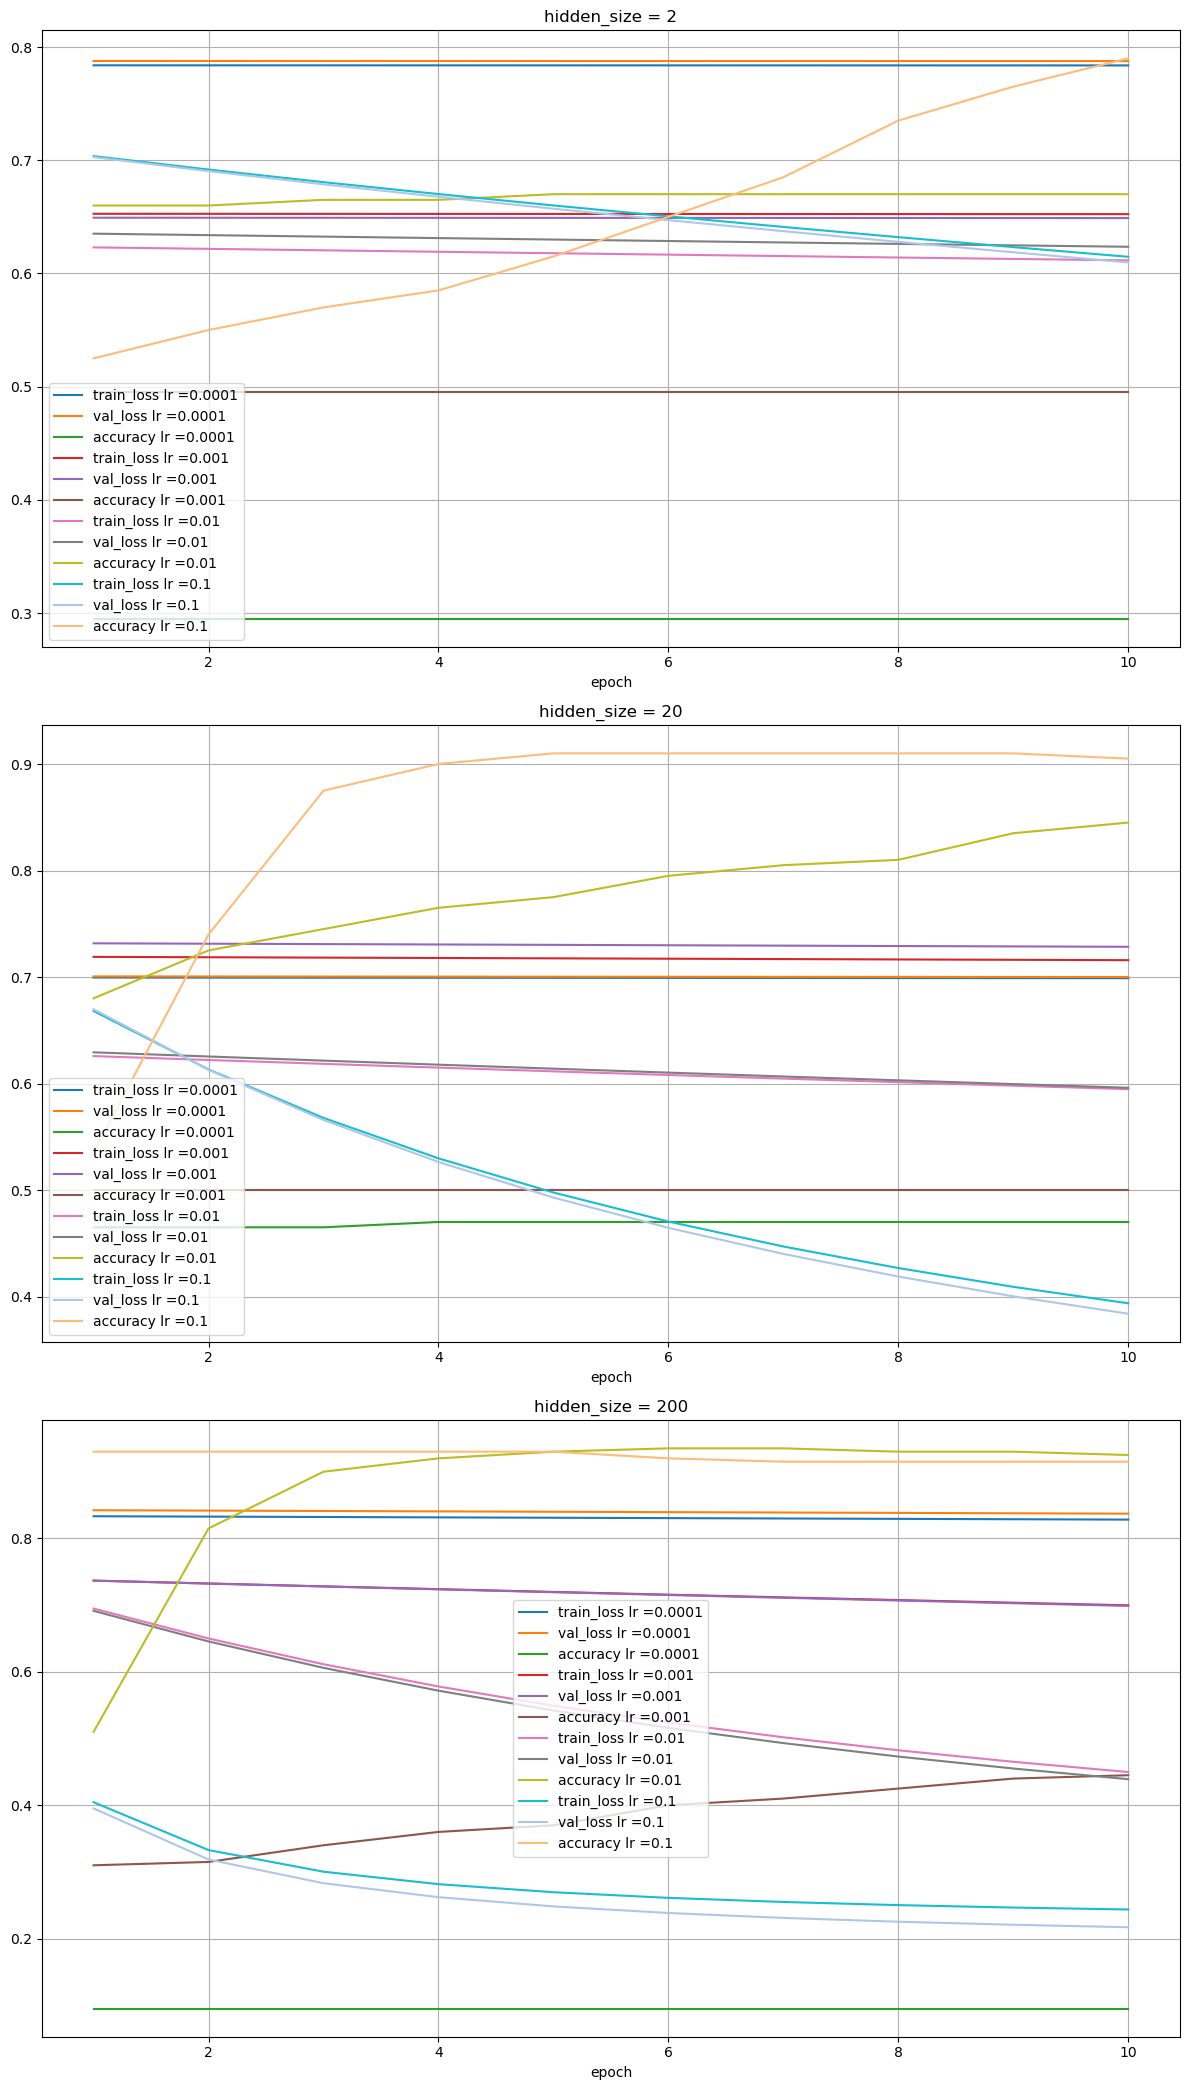

In [165]:
# Визуализация обучения
# Исследование `train_loss`, `val_loss` и `accuracy` в процессе обучения нейронной сети при разном `количестве нейронов в скрытом слое` (2, 20, 200).

n = len(list_hidden_size)
plt.figure(figsize=(12, 21))
x = [i for i in range(1,11)]
for i in range(len(list_hidden_size)):
    k=0
    for j in range(len(list_lr)):
        plt.subplot(n, 1, i+1)
        plt.plot(x, train_loss[i+j*len(list_hidden_size)], color=colors[k], label='train_loss lr ='+str(list_lr[j]))
        plt.plot(x, val_loss[i+j*len(list_hidden_size)], color=colors[k+1], label='val_loss lr ='+str(list_lr[j]))
        plt.plot(x, accuracy[i+j*len(list_hidden_size)], color=colors[k+2], label='accuracy lr ='+str(list_lr[j]))
        k+=3
    plt.title(f'hidden_size = {list_hidden_size[i]}')
    plt.grid(True)
    plt.legend()
    plt.xlabel('epoch')
plt.tight_layout()
plt.show()

**Вывод:**
При малой скорости обучения 10 эпох недостаточно. Малое количество нейронов приводит к недообучению. Большое количество - к переобучению.

## Задание 3
Сгенерируйте новые данные из (код приведён ниже). В чем заключается отличие новых данных от данных из предыдущих заданий? Повторите эксперименты из задания 2 для новых данных.

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

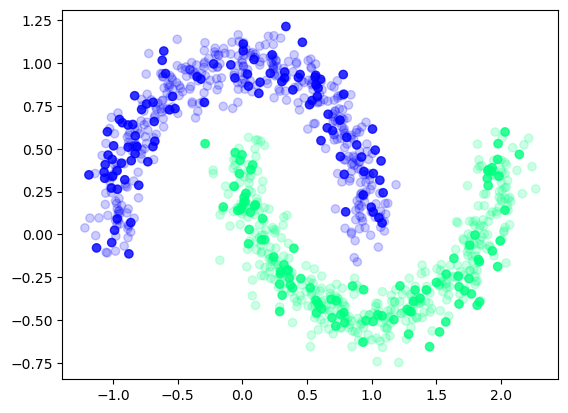

In [167]:
data, labels = make_moons(n_samples=1000, noise=0.1, random_state=42)

train_X, val_X, train_y, val_y = train_test_split(data, labels.reshape(-1,1), test_size=0.2, stratify=labels, random_state=43)

train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.float32)
val_X = val_X.astype(np.float32)
val_y = val_y.astype(np.float32)

plt.scatter(train_X[:,0], train_X[:,1], c=train_y, cmap='winter', alpha=0.2)
plt.scatter(val_X[:,0], val_X[:,1], c=val_y, cmap='winter', alpha=0.8)

In [168]:
f = lambda x: torch.from_numpy(x)

train_X = f(train_X)
train_y = f(train_y)
val_X = f(val_X)
val_y = f(val_y)

In [169]:
from itertools import product

list_lr = [0.0001,  0.001, 0.01, 0.1]
list_hidden_size = [2, 20, 200]

train_loss = []
val_loss = []
accuracy = []

for lr, hidden_size in product(list_lr, list_hidden_size):
    # Инициализация данных и модели
    model = SimpleNN(hidden_size=hidden_size)  # Скрытый слой из 2 нейронов по умолчанию
    print(f'\nhidden_size = {hidden_size}, lr = {lr}')  
    print(f'Количество нейронов = {2+hidden_size+1}')
    print(f'Количество параметров (весов) = {(2*hidden_size+hidden_size)+0+(hidden_size*1+1)+0}\n') # Суммируется по каждому слою (кол-во входов * кол-во выходов + кол-во смещений)
  
    # Вычисление accuracy до обучения
    with torch.no_grad():
        predictions = model(val_X)
        pred_labels = (predictions > 0.5).float()
        initial_accuracy = accuracy_score(val_y.squeeze().numpy(), pred_labels.numpy())
    print(f"Accuracy до обучения: {initial_accuracy:.4f}")
    
    # Обучение модели
    fn_loss = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.SGD(model.parameters(), lr=lr)

    tr_loss = []
    v_loss = []
    acc = []
    n_epochs = 10
    for epoch in range(n_epochs):
        # Forward pass
        predictions = model(train_X)
        loss = fn_loss(predictions.squeeze(), train_y.squeeze().float())
        #tr_loss.append(loss.item())
        
        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            predictions = model(train_X)
            loss = fn_loss(predictions.squeeze(), train_y.squeeze().float())
            tr_loss.append(loss.item())
        
            predictions_val = model(val_X)
            loss_val = fn_loss(predictions_val.squeeze(), val_y.squeeze().float())
            v_loss.append(loss_val.item())
            
            pred_labels = (predictions_val > 0.5).float()
            trained_accuracy = accuracy_score(val_y.squeeze().numpy(), pred_labels.numpy())
            #print(f"Accuracy после обучения: {trained_accuracy:.4f}")
            acc.append(trained_accuracy)
      
        # Вывод прогресса
        print(f'Epoch [{epoch+1}/{n_epochs}], train_Loss: {loss.item():.4f}, val_Loss: {loss_val.item():.4f}, accuracy на валидации: {trained_accuracy}')

    train_loss.append(tr_loss)
    val_loss.append(v_loss)
    accuracy.append(acc)

    # Вычисление accuracy после обучения
    with torch.no_grad():
        predictions = model(val_X)
        pred_labels = (predictions > 0.5).float()
        trained_accuracy = accuracy_score(val_y.squeeze().numpy(), pred_labels.numpy())
    print(f"Accuracy после обучения: {trained_accuracy:.4f}")



hidden_size = 2, lr = 0.0001
Количество нейронов = 5
Количество параметров (весов) = 9

Accuracy до обучения: 0.4100
Epoch [1/10], train_Loss: 0.7085, val_Loss: 0.7054, accuracy на валидации: 0.41
Epoch [2/10], train_Loss: 0.7085, val_Loss: 0.7054, accuracy на валидации: 0.41
Epoch [3/10], train_Loss: 0.7085, val_Loss: 0.7054, accuracy на валидации: 0.41
Epoch [4/10], train_Loss: 0.7085, val_Loss: 0.7054, accuracy на валидации: 0.41
Epoch [5/10], train_Loss: 0.7085, val_Loss: 0.7054, accuracy на валидации: 0.41
Epoch [6/10], train_Loss: 0.7085, val_Loss: 0.7054, accuracy на валидации: 0.41
Epoch [7/10], train_Loss: 0.7085, val_Loss: 0.7054, accuracy на валидации: 0.41
Epoch [8/10], train_Loss: 0.7085, val_Loss: 0.7054, accuracy на валидации: 0.41
Epoch [9/10], train_Loss: 0.7085, val_Loss: 0.7054, accuracy на валидации: 0.41
Epoch [10/10], train_Loss: 0.7085, val_Loss: 0.7054, accuracy на валидации: 0.41
Accuracy после обучения: 0.4100

hidden_size = 20, lr = 0.0001
Количество нейроно

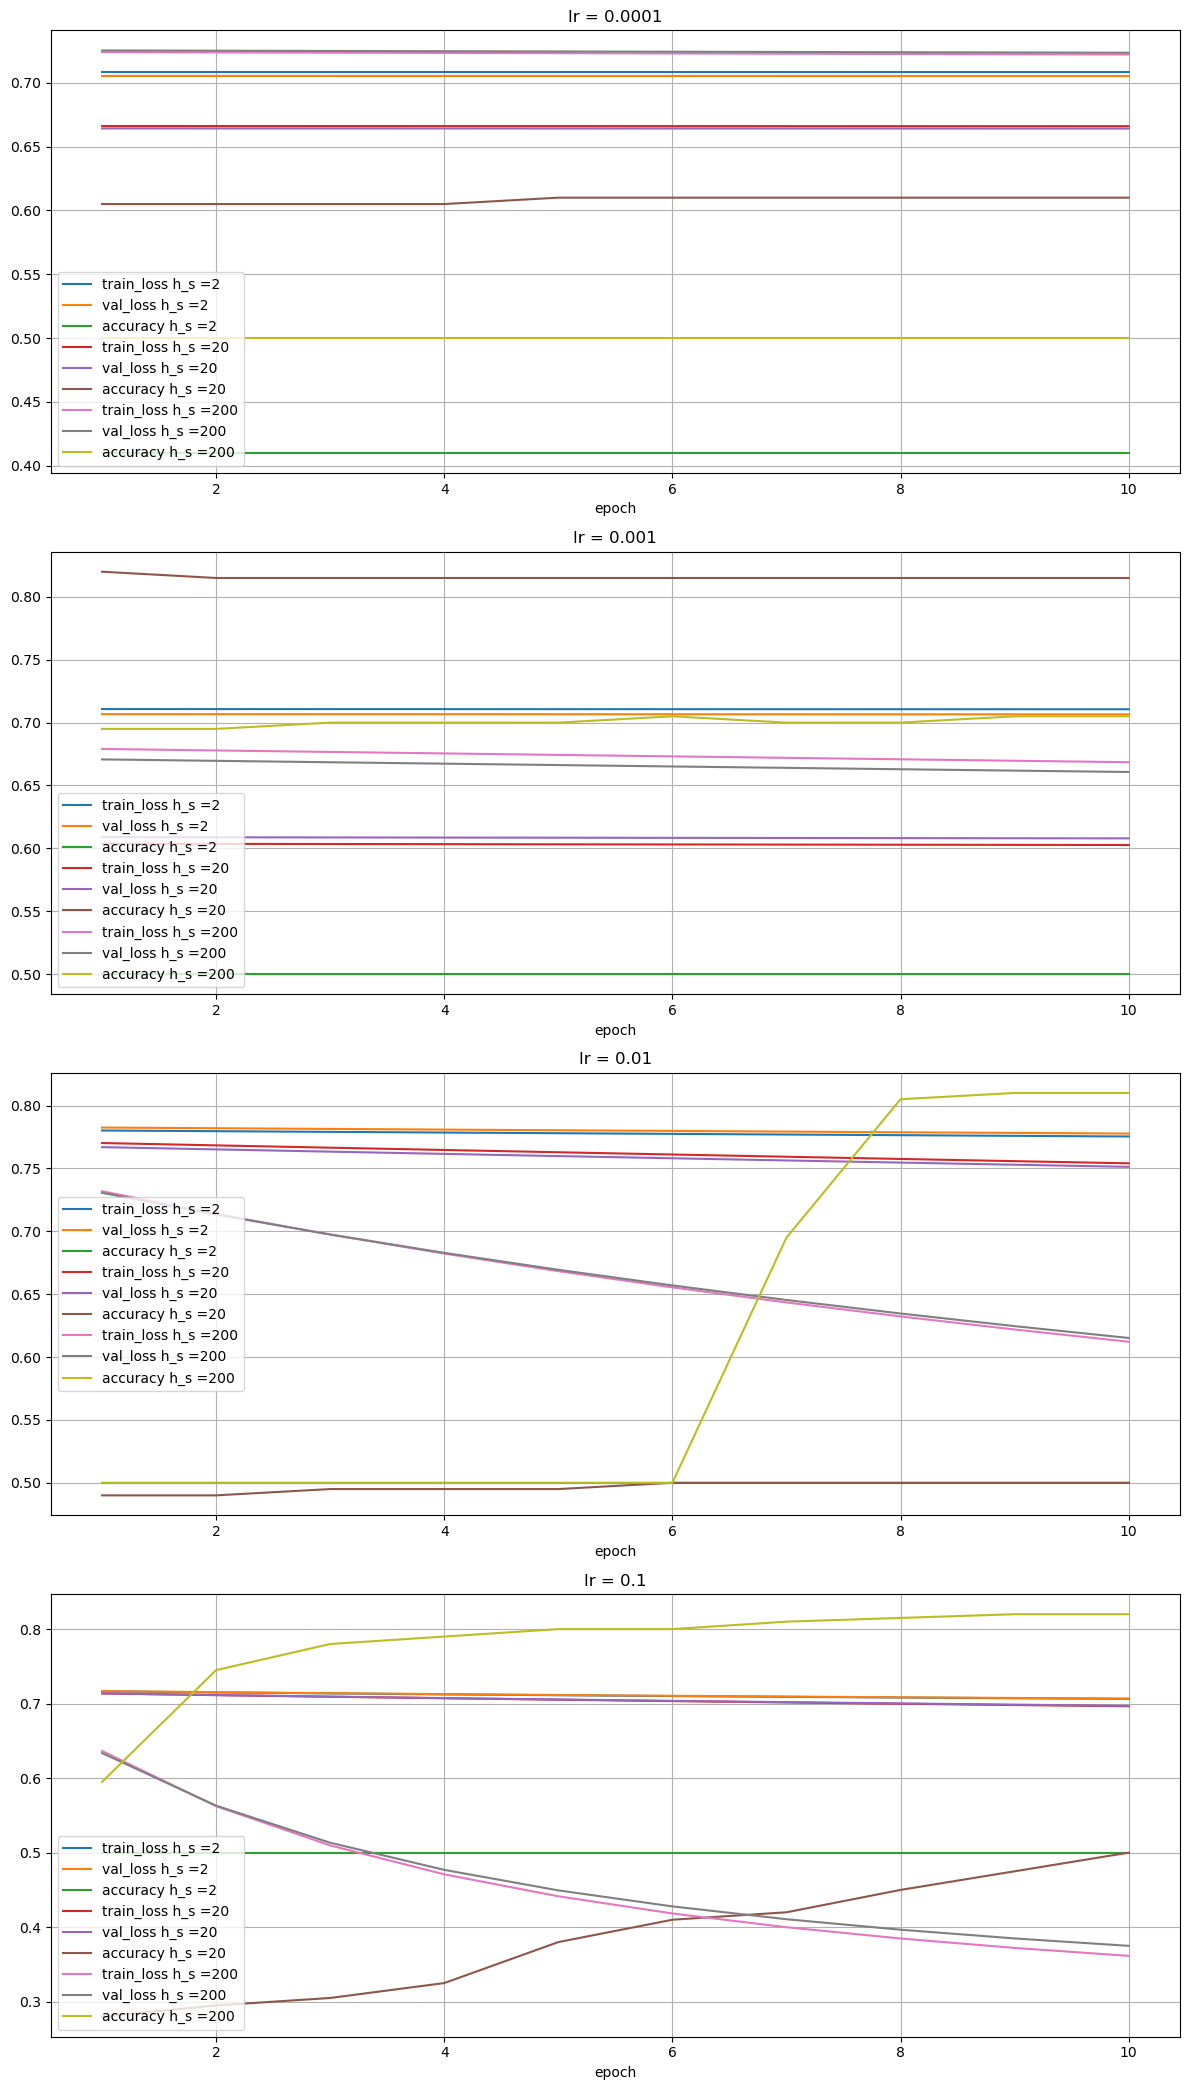

In [170]:
# Визуализация обучения
# Исследование `train_loss`, `val_loss` и `accuracy` в процессе обучения нейронной сети при разной `скорости обучения` (0.1, 0.01, 0.001, 0.0001).
n = len(list_lr)
# Создаем график

plt.figure(figsize=(12, 21))
x = [i for i in range(1,11)]
for i in range(len(list_lr)):
    k=0
    for j in range(len(list_hidden_size)):
        plt.subplot(n, 1, i+1)
        plt.plot(x, train_loss[i*len(list_hidden_size)+j], color=colors[k], label='train_loss h_s ='+str(list_hidden_size[j]))
        plt.plot(x, val_loss[i*len(list_hidden_size)+j], color=colors[k+1], label='val_loss h_s ='+str(list_hidden_size[j]))
        plt.plot(x, accuracy[i*len(list_hidden_size)+j], color=colors[k+2], label='accuracy h_s ='+str(list_hidden_size[j]))
        k+=3    
    plt.title(f'lr = {list_lr[i]}')
    plt.grid(True)
    plt.legend()
    plt.xlabel('epoch')
        #plt.ylabel('')
plt.tight_layout()
plt.show()

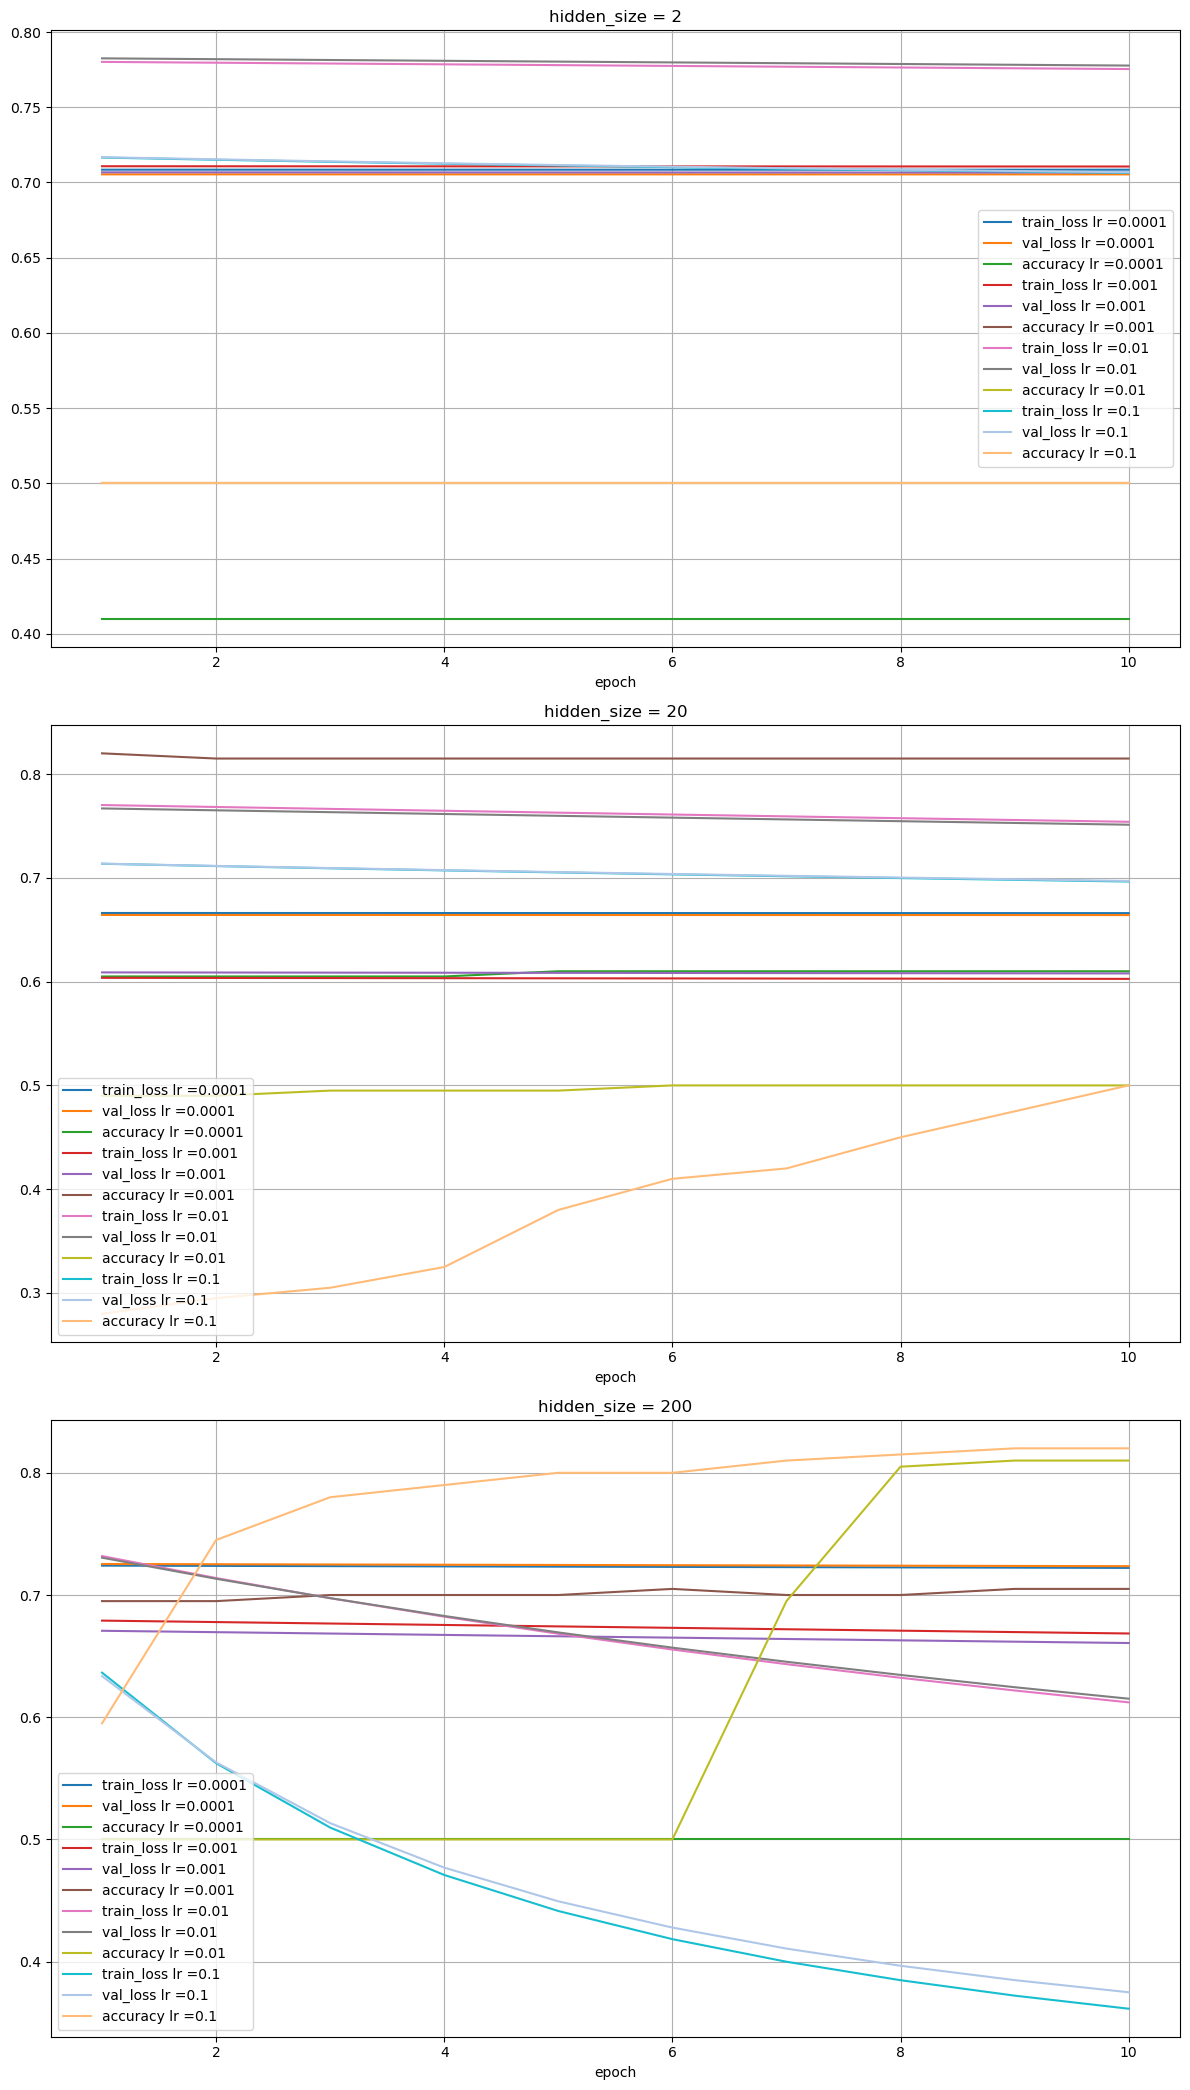

In [171]:
# Визуализация обучения
# Исследование `train_loss`, `val_loss` и `accuracy` в процессе обучения нейронной сети при разном `количестве нейронов в скрытом слое` (2, 20, 200).

# Создаем график
n = len(list_hidden_size)
plt.figure(figsize=(12, 21))
x = [i for i in range(1,11)]
for i in range(len(list_hidden_size)):
    k=0
    for j in range(len(list_lr)):
        plt.subplot(n, 1, i+1)
        plt.plot(x, train_loss[i+j*len(list_hidden_size)], color=colors[k], label='train_loss lr ='+str(list_lr[j]))
        plt.plot(x, val_loss[i+j*len(list_hidden_size)], color=colors[k+1], label='val_loss lr ='+str(list_lr[j]))
        plt.plot(x, accuracy[i+j*len(list_hidden_size)], color=colors[k+2], label='accuracy lr ='+str(list_lr[j]))
        k+=3
    plt.title(f'hidden_size = {list_hidden_size[i]}')
    plt.grid(True)
    plt.legend()
    plt.xlabel('epoch')
plt.tight_layout()
plt.show()

**Вывод:**
При малой скорости обучения 10 эпох недостаточно. Малое количество нейронов приводит к недообучению. Большое количество - к переобучению.